# Density Model: DBSCAN

The Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is based on the intuitive notion of "clusters" and "noise". The key idea is that for each point of a cluster, the neighborhood of a given radius has to contain at least a minimum number of points. 

While K-Means clustering is easy to apply, it does not deal well with outliers due to the way it constructs the clusters. It assigns all the points to a cluster in which outliers are also assigned to clusters in which they may not belong. This a big problem for anomaly detection because anomalous points will also be assigned to a cluster and they will also pull the centroid of the clusters towards them, making it even harder to identify them as anomalies.

This is where density based clustering run to our help. In comparison to centroid based clustering like K-Means clustering, density based models identify the dense areas of cluster points, making it possible to learn clusters of arbitrary shape and therefore identify outliers/anomalies in the dataset.

Example for spherical or convex shaped clusters where K-means and hierarchical clustering would work well.

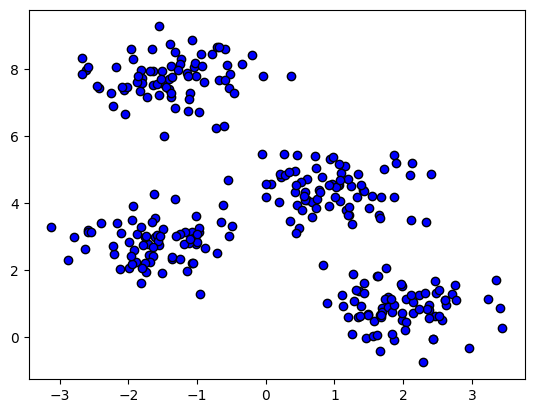

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
plt.plot(X[:,0], X[:,1], 'o', markerfacecolor='b', markeredgecolor='k',markersize=6)

Example for a dataset with arbitrary shape and a lot of noise:

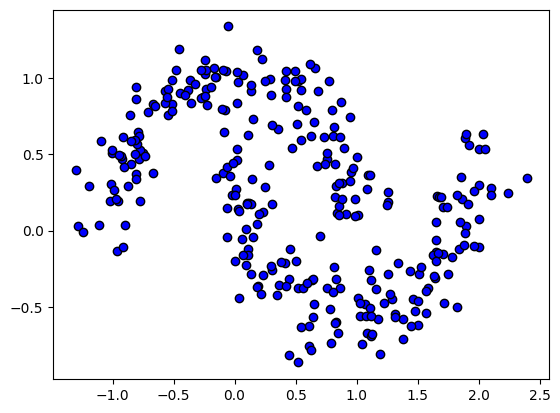

In [3]:
from sklearn.datasets import make_moons

moons_X, moon_y = make_moons(n_samples = 300, noise= 0.15, random_state=0)
plt.plot(moons_X[:,0], moons_X[:,1], 'o', markerfacecolor='b', markeredgecolor='k', markersize=6)

## Important Parameters

DBSCAN algorithm works on two important parameters:

1. <b>Epsilon (ϵ)</b>: This parameters determines the distance around a data point which defines the neighborhood of that point. If the distance between two points is less than this value, then they will be considered as neighbors. This parameter is important when it comes to determining the outliers. If Epsilon is chosen too small, then most of the data will be considered as outliers. If it is chosen too large, then many clusters will merge together forming a large clusters including majority of the data points.

    How do we decide which Epsilon value is the best? We can use K-distance graph to find the best value.

<p align="center">
<img src="figs/1_ytLv0Sw0DFuzDXLOKVVoRg.webp">
</p>

2. <b>Minimum number of neighbors</b>: Minimum number of neighbors within eps radius. This parameter should be chosen larger for larger datasets. Generally this parameter can be determined from the number of dimensions (D) in data. It should be larger or equal to dimensionality of the dataset.

The three types of data points that exist in this model are:

1. Core Point: A data point which has more than the minimum number of samples parameter in its neighborhood.

2. Border Point: A data point which has points less than the minimum number of samples parameter within its neighborhood but it is in the epsilon range (neigborhood) of another core point.

3. Noise / Outlier Point: A data point which is neither a core point or a border point.

In the figure below, we can see that a potential candidate for a core point, can not be a core point when the minimum samples parameter is selected as four. It only has three points (including itself= within its neighborhood and therefore does not meet the threshold requirement. However the point below seems satisfy the requirement with 6 points within its neighborhood.

<p align="center">
<img src="figs/1_lEhxQh01DamEKpOOpE1N5A.webp">
</p>

DBSCAN model steps:

1. Select a random data point from the data

2. Determine the number of points within its neighborhood using epsilon. If it is more than than the minimum samples parameter, assign it as a cluster. If less, than as noise/outlier point.

3. We add the neighborhood as a part of the cluster. This results in neighborhood of each data point in the cluster also adding to the cluster distance. This way the cluster enlarges with new data points as their neighborhood (epsilon) is also added to the cluster until no further data points can be added to the cluster

4. The steps 2–4 are repeated until all data points have been selected and labeled

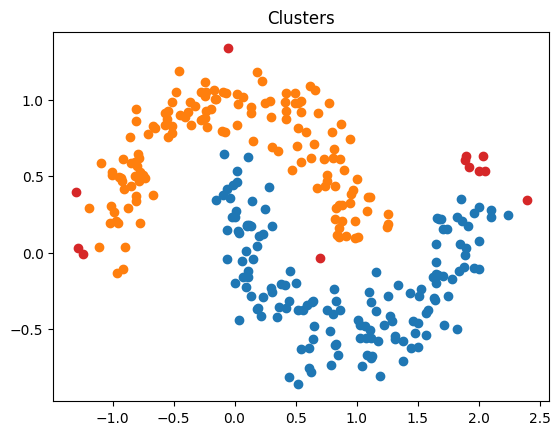

In [4]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 0.2, min_samples=7).fit(moons_X)
clusters = db.labels_
plt.scatter(moons_X[clusters == 0, 0], moons_X[clusters == 0, 1], label = 'Type 1')
plt.scatter(moons_X[clusters == 1, 0], moons_X[clusters == 1, 1], label = 'Type 2')
plt.scatter(moons_X[clusters == 2, 0], moons_X[clusters == 2, 1], label = 'Type 3')
plt.scatter(moons_X[clusters == -1, 0], moons_X[clusters == -1, 1], label = 'Outlier')
plt.title('Clusters')
plt.show()

We have talked enough about the DBSCAN model and its concept. We can use the DBSCAN model from Sklearn to cluster the iris dataset and compare its performance to other clustering algorithms.

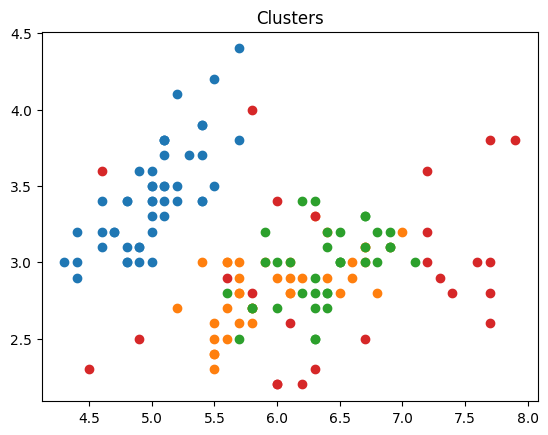

In [5]:
from sklearn.datasets import load_iris
iris_data = load_iris()
data = iris_data.data

db = DBSCAN(eps = 0.4, min_samples=4).fit(data) 
# we can play with the epsion variable and see how choosing a large # value creates a single large cluster and choosing a small value, 
# creates small clusters with many outliers
clusters = db.labels_
plt.scatter(data[clusters == 0, 0], data[clusters == 0, 1], label = 'Type 1')
plt.scatter(data[clusters == 1, 0], data[clusters == 1, 1], label = 'Type 2')
plt.scatter(data[clusters == 2, 0], data[clusters == 2, 1], label = 'Type 3')
plt.scatter(data[clusters == -1, 0], data[clusters == -1, 1], label = 'Outlier')
plt.title('Clusters')
plt.show()

## How to select Epsilon?

We can use the K-distance graph which we previously mentioned to find an ideal epsilon value. K-distance graph shows us the distance between each data point and its K nearest neigbors. For this we have to calculate the Nearest Neighbors and their distance using the NearestNeighbors from sklearn. The average distances are then plotted against the number of points used to calculate the distance. The most optimal value as epsilon is the distance where the graph has the highest curvature (at the elbow). Looking at the graph we can easily intrepret that this point signals us the point where the density border of the cluster lies. After this point, the average distance increases greatly with fewer number of points, because they lay farther than the rest of the points (potential outliers).

This point represents the optimization point where diminishing returns are no longer worth the additional cost. This concept of diminishing returns applies here because while increasing the number of clusters will always improve the fit of the model, it also increases the risk that overfitting will occur.

Let’s calculate the ideal epsilon for iris dataset. We can use the min samples value that we have used as the value for number of neighbors.

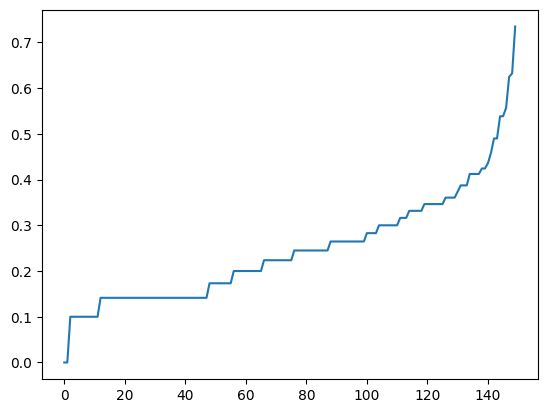

In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(data)
distances, indices = neighbors_fit.kneighbors(data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

As seen, the highest curvature is reached at average distance 0.4, which would also the epsilon which we used previously.

## Disadvantage Of K-MEANS:

- K-Means forms spherical clusters only. This algorithm fails when data is not spherical ( i.e. same variance in all directions). 

<img src="figs/PicsArt_11-17-08.07.10-300x300.jpg">

- K-Means algorithm is sensitive towards outlier. Outliers can skew the clusters in K-Means in very large extent. 

<img src="figs/fig-1-300x300.jpeg">

- K-Means algorithm requires one to specify the number of clusters a priory etc.

Basically, DBSCAN algorithm overcomes all the above-mentioned drawbacks of K-Means algorithm. DBSCAN algorithm identifies the dense region by grouping together data points that are closed to each other based on distance measurement.

## References

[What is Clustering in Machine Learning](https://python.plainenglish.io/lets-talk-about-clustering-in-machine-learning-13a78ac025e3)

[DBSCAN Clustering in ML | Density based clustering](https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/)